In [14]:
# 쉬는날을 찾기

import random
import pandas as pd
import numpy as np
import os
import holidays

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings(action='ignore') 
korea_holidays = holidays.SouthKorea(years=2023)
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [137]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

# target = []
# for date, name in sorted(korea_holidays.items()):
#     target.append(str(date))
# train['Isholiday'] = train['timestamp'].apply(lambda x: 1 if x in target else 0)
# test['Isholiday'] = test['timestamp'].apply(lambda x: 1 if x in target else 0)

# # train = train.drop(train[(train['supply(kg)'] > 0) & (train['price(원/kg)'] == 0)].index)
# # train = train.reset_index(drop=True)
train[(train['supply(kg)'] > 0) & (train['price(원/kg)'] == 0)]['supply(kg)'] = 0

# train['timestamp'] = pd.to_datetime(train['timestamp'])
# test['timestamp'] = pd.to_datetime(test['timestamp'])
# train['Is_Sunday'] = train['timestamp'].dt.day_name() == 'Sunday'
# test['Is_Sunday'] = test['timestamp'].dt.day_name() == 'Sunday'

# # no supply -> no price
# # train['classify'] = train['supply(kg)'].apply(lambda x: 0 if x == 0 else 1)
# train['Is_Sunday'] = train['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    
# test['Is_Sunday'] = test['Is_Sunday'].apply(lambda x: 0 if x == False else 1)
# train[(train['Is_Sunday'] == 1) & (train['price(원/kg)'] > 0)]['price(원/kg)'] = 0
# tar = train[(train['Is_Sunday'] == 1) & (train['price(원/kg)'] > 0)].index
# train = train.drop(tar)

# train['timestamp'] = train['timestamp'].astype('str')
# train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
# train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))
# train['day'] = train['timestamp'].apply(lambda x : int(x[8:10]))

# test['timestamp'] = test['timestamp'].astype('str')
# test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
# test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))
# test['day'] = test['timestamp'].apply(lambda x : int(x[8:10]))

# qual_col = ['item', 'corporation', 'location']

# for i in qual_col:
#     le = LabelEncoder()
#     train[i]=le.fit_transform(train[i])
#     test[i]=le.transform(test[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

# train = train.drop(['supply(kg)','ID','timestamp'],axis=1)
# test = test.drop(['timestamp'],axis=1) # ID

# train = train[train['price(원/kg)'] < 7500].reset_index(drop=True)
train[train['price(원/kg)'] > 8000]['price(원/kg)'] = 8000
print('Done.')

train.info()
# test_df = pd.read_csv('test.csv')[['ID','timestamp']]

Done.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.2+ MB


In [138]:
train

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


In [139]:
target = [i.reset_index(drop=True) for i in pd.DataFrame(train.groupby('location'))[1]]
for i in range(len(target)):
    target[i]['item_id'] = target[i].ID.str[0:6]
    target[i] = target[i][['timestamp', 'supply(kg)', 'price(원/kg)','item_id']]
    target[i] = target[i].reset_index(drop=True)

In [140]:
pred = []
for tar in target:
    data = TimeSeriesDataFrame(tar)
    predictor = TimeSeriesPredictor( 
        prediction_length=28,
        target="price(원/kg)",
        eval_metric="RMSE",
    )
    # seed 고정
    predictor.fit(data, random_seed=572)
    predictor.refit_full()
    pred.append(predictor.predict(data, random_seed=572))


================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'default',
 'num_val_windows': 1,
 'prediction_length': 28,
 'random_seed': 572,
 'target': 'price(원/kg)',
 'time_limit': None,
 'verbosity': 2}
Provided training data set with 35029 rows, 23 items (item = single time series). Average time series length is 1523.0. Data frequency is 'D'.
Global seed set to 572
AutoGluon will save models to AutogluonModels\ag-20231119_163441\
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'price(원/kg)'
	past covariates:  ['supply(kg)']

Starting training. Start time is 2

In [150]:
predict = [i.reset_index() for i in pred]
for _ in range(len(predict)):
    for i in predict:
        i['custom'] = (i['0.3'] + 2*i['0.4'] + 3*i['0.5'] + 2*i['0.6'] + i['0.7'])/9
predict[0]

,item_id,timestamp,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,custom
0,TG_A_J,2023-03-04,3409.320595,902.201971,1774.590202,2406.881829,2941.113081,3418.204384,3882.827487,4408.742821,4996.129357,5872.655223,3413.124327
1,TG_A_J,2023-03-05,985.801064,-1964.634331,-952.073741,-221.783491,402.148147,985.306216,1568.582411,2192.661073,2922.986601,3936.526744,985.361928
2,TG_A_J,2023-03-06,3098.879348,-873.402035,495.901923,1487.728488,2309.103238,3077.914504,3864.475648,4702.643977,5685.106772,7040.172570,3085.697083
3,TG_A_J,2023-03-07,3509.570620,-1090.190706,558.140290,1700.241549,2656.318312,3539.823305,4413.808951,5383.921846,6513.978244,8076.301459,3538.209760
4,TG_A_J,2023-03-08,3336.012433,-1838.551615,-37.163931,1236.460511,2298.821356,3288.817243,4294.558430,5360.936242,6587.573867,8311.839360,3294.512006
...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,RD_F_J,2023-03-27,517.414257,-271.833662,9.528159,205.377611,365.874823,519.098995,671.955659,838.134221,1029.134598,1303.633069,519.607753
640,RD_F_J,2023-03-28,534.957276,-283.928586,10.858420,213.412231,382.398046,538.153336,697.261517,863.895571,1063.098582,1341.080504,539.009660
641,RD_F_J,2023-03-29,566.230291,-287.504091,18.917948,230.291496,400.157558,558.786169,716.970001,890.124331,1089.038255,1382.850629,559.003272
642,RD_F_J,2023-03-30,528.127538,-333.197532,-22.067302,187.954700,370.761271,530.515279,693.568985,866.239241,1073.998670,1362.790930,530.488921


In [151]:
pd.read_csv('./location-split-reg.csv')

,ID,answer
0,TG_A_J_20230304,3297.871619
1,TG_A_J_20230305,91.655319
2,TG_A_J_20230306,3025.902565
3,TG_A_J_20230307,3511.170886
4,TG_A_J_20230308,3224.376032
...,...,...
1087,RD_F_J_20230327,525.178751
1088,RD_F_J_20230328,555.639653
1089,RD_F_J_20230329,570.425733
1090,RD_F_J_20230330,537.417772


In [153]:
pd.read_csv('./loc-split-reg-custom.csv')

,ID,answer
0,TG_A_J_20230304,3413.124327
1,TG_A_J_20230305,91.655319
2,TG_A_J_20230306,3085.697083
3,TG_A_J_20230307,3538.209760
4,TG_A_J_20230308,3294.512006
...,...,...
1087,RD_F_J_20230327,519.607753
1088,RD_F_J_20230328,539.009660
1089,RD_F_J_20230329,559.003272
1090,RD_F_J_20230330,530.488921


In [152]:
submission = pd.read_csv('./open/sample_submission.csv')
pred_df = pd.DataFrame()
for i in predict:
    pred_df = pd.concat([pred_df,i])
pred_df = pred_df[['item_id','timestamp','custom']]
pred_df.sort_values(['item_id','timestamp'])['custom']

submission = submission.sort_values('ID')
submission['answer'] = pred_df.sort_values(['item_id','timestamp'])['custom'].values
submission = submission.reset_index()
submission = submission.sort_values('index')
submission = submission.drop('index',axis=1).reset_index(drop=True)


ans = []
check = 7
for i in submission['ID'].astype('str'):
    
    dt = i[check:check+4] + '-' + i[check+4:check+6] + '-' + i[check+6:]
    ans.append(dt)
    
submission['datestamp'] = ans


submission['regression'] = pd.read_csv('./cut_price.csv')['answer']
submission['datestamp'] = pd.to_datetime(submission['datestamp'])
submission['Is_Sunday'] = submission['datestamp'].dt.day_name() == 'Sunday'

ans = []
for tar in submission.values:
    if tar[4] == True:
        ans.append(tar[3])
    else:
        ans.append(tar[1])
        
submission = pd.read_csv('./open/sample_submission.csv')
submission['answer'] = ans

ans = []
for i in submission['answer']:
    if i < 0:
        ans.append(0)
    else:
        ans.append(i)
submission['answer'] = ans
# submission = submission.loc[submission['answer'] < 0.0, 'answer'] = 0.0
# submission.to_csv('./reg-ts-onlyprice.csv', index=False)

submission.to_csv('./loc-split-reg-custom.csv', index=False)


<Axes: >

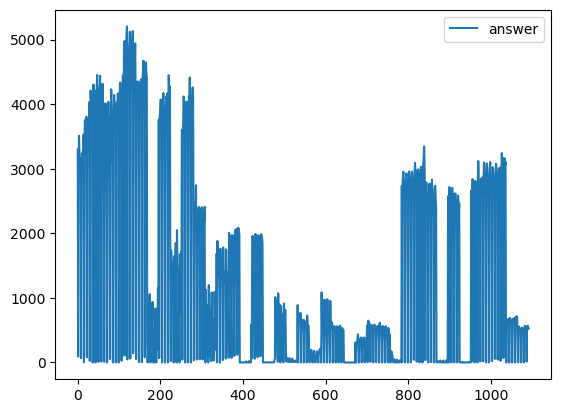

In [135]:
submission.plot()

In [126]:
# sub = pd.read_csv('./open/sample_submission.csv')
# ans = (pd.read_csv('./reg-ts28-best-0cut.csv')['answer'] + submission['answer'])/2
# sub['answer'] = ans
# sub.to_csv('./enssemble.csv', index=False)


In [ ]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

# target = []
# for date, name in sorted(korea_holidays.items()):
#     target.append(str(date))
# train['Isholiday'] = train['timestamp'].apply(lambda x: 1 if x in target else 0)
# test['Isholiday'] = test['timestamp'].apply(lambda x: 1 if x in target else 0)

# # train = train.drop(train[(train['supply(kg)'] > 0) & (train['price(원/kg)'] == 0)].index)
# # train = train.reset_index(drop=True)
# train[(train['supply(kg)'] > 0) & (train['price(원/kg)'] == 0)]['supply(kg)'] = 0

# train['timestamp'] = pd.to_datetime(train['timestamp'])
# test['timestamp'] = pd.to_datetime(test['timestamp'])
# train['Is_Sunday'] = train['timestamp'].dt.day_name() == 'Sunday'
# test['Is_Sunday'] = test['timestamp'].dt.day_name() == 'Sunday'

# # no supply -> no price
# # train['classify'] = train['supply(kg)'].apply(lambda x: 0 if x == 0 else 1)
# train['Is_Sunday'] = train['Is_Sunday'].apply(lambda x: 0 if x == False else 1)    
# test['Is_Sunday'] = test['Is_Sunday'].apply(lambda x: 0 if x == False else 1)
# train[(train['Is_Sunday'] == 1) & (train['price(원/kg)'] > 0)]['price(원/kg)'] = 0
# tar = train[(train['Is_Sunday'] == 1) & (train['price(원/kg)'] > 0)].index
# train = train.drop(tar)

# train['timestamp'] = train['timestamp'].astype('str')
# train['year'] = train['timestamp'].apply(lambda x : int(x[0:4]))
# train['month'] = train['timestamp'].apply(lambda x : int(x[5:7]))
# train['day'] = train['timestamp'].apply(lambda x : int(x[8:10]))

# test['timestamp'] = test['timestamp'].astype('str')
# test['year'] = test['timestamp'].apply(lambda x : int(x[0:4]))
# test['month'] = test['timestamp'].apply(lambda x : int(x[5:7]))
# test['day'] = test['timestamp'].apply(lambda x : int(x[8:10]))

# qual_col = ['item', 'corporation', 'location']

# for i in qual_col:
#     le = LabelEncoder()
#     train[i]=le.fit_transform(train[i])
#     test[i]=le.transform(test[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

# train = train.drop(['supply(kg)','ID','timestamp'],axis=1)
# test = test.drop(['timestamp'],axis=1) # ID

# train = train[train['price(원/kg)'] < 7500].reset_index(drop=True)
# train[train['price(원/kg)'] > 8000]['price(원/kg)'] = 8000
print('Done.')

train.info()
# test_df = pd.read_csv('test.csv')[['ID','timestamp']]

In [136]:
train = pd.read_csv('./open/train.csv')
target = [i.reset_index(drop=True) for i in pd.DataFrame(train.groupby('corporation'))[1]]
for i in range(len(target)):
    target[i]['item_id'] = target[i].ID.str[0:6]
    target[i] = target[i][['timestamp', 'supply(kg)', 'price(원/kg)','item_id']]
    target[i] = target[i].reset_index(drop=True)
    
pred = []
for tar in target:
    data = TimeSeriesDataFrame(tar)
    predictor = TimeSeriesPredictor( 
        prediction_length=28,
        target="price(원/kg)",
        eval_metric="RMSE",
    )
    # seed 고정
    predictor.fit(data, random_seed=42)
    predictor.refit_full()
    pred.append(predictor.predict(data, random_seed=42))

predict = [i.reset_index() for i in pred]

submission = pd.read_csv('./open/sample_submission.csv')
pred_df = pd.DataFrame()
for i in predict:
    pred_df = pd.concat([pred_df,i])
pred_df = pred_df[['item_id','timestamp','mean']]
pred_df.sort_values(['item_id','timestamp'])['mean']

submission = submission.sort_values('ID')
submission['answer'] = pred_df.sort_values(['item_id','timestamp'])['mean'].values
submission = submission.reset_index()
submission = submission.sort_values('index')
submission = submission.drop('index',axis=1).reset_index(drop=True)


ans = []
check = 7
for i in submission['ID'].astype('str'):
    
    dt = i[check:check+4] + '-' + i[check+4:check+6] + '-' + i[check+6:]
    ans.append(dt)
    
submission['datestamp'] = ans


submission['regression'] = pd.read_csv('./cut_price.csv')['answer']
submission['datestamp'] = pd.to_datetime(submission['datestamp'])
submission['Is_Sunday'] = submission['datestamp'].dt.day_name() == 'Sunday'

ans = []
for tar in submission.values:
    if tar[4] == True:
        ans.append(tar[3])
    else:
        ans.append(tar[1])
        
submission = pd.read_csv('./open/sample_submission.csv')
submission['answer'] = ans

ans = []
for i in submission['answer']:
    if i < 0:
        ans.append(0)
    else:
        ans.append(i)
submission['answer'] = ans
# submission = submission.loc[submission['answer'] < 0.0, 'answer'] = 0.0
# submission.to_csv('./reg-ts-onlyprice.csv', index=False)

submission.to_csv('./corp-split-reg.csv', index=False)



================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'RMSE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'default',
 'num_val_windows': 1,
 'prediction_length': 28,
 'random_seed': 42,
 'target': 'price(원/kg)',
 'time_limit': None,
 'verbosity': 2}
Provided training data set with 13707 rows, 9 items (item = single time series). Average time series length is 1523.0. Data frequency is 'D'.
Global seed set to 42
AutoGluon will save models to AutogluonModels\ag-20231119_152145\
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'price(원/kg)'
	past covariates:  ['supply(kg)']

Starting training. Start time is 2023

Global seed set to 42
AutoGluon will save models to AutogluonModels\ag-20231119_154301\
AutoGluon will gauge predictive performance using evaluation metric: 'RMSE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'price(원/kg)'
	past covariates:  ['supply(kg)']

Starting training. Start time is 2023-11-20 00:43:01
Models that will be trained: ['Naive', 'SeasonalNaive', 'Theta', 'AutoETS', 'RecursiveTabular', 'DeepAR']
Training timeseries model Naive. 
	-1298.2397    = Validation score (-RMSE)
	0.02    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. 
	-1176.7989    = Validation score (-RMSE)
	0.03    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model Theta. 
	-1152.9454    = Validation score (-RMSE)
	0.02    s     = 


Starting training. Start time is 2023-11-20 01:04:45
Models that will be trained: ['Naive', 'SeasonalNaive', 'Theta', 'AutoETS', 'RecursiveTabular', 'DeepAR']
Training timeseries model Naive. 
	-899.9021     = Validation score (-RMSE)
	0.02    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. 
	-666.8681     = Validation score (-RMSE)
	0.03    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model Theta. 
	-641.7612     = Validation score (-RMSE)
	0.02    s     = Training runtime
	24.24   s     = Validation (prediction) runtime
Training timeseries model AutoETS. 
	-603.1941     = Validation score (-RMSE)
	0.03    s     = Training runtime
	2.08    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. 
	-782.0459     = Validation score (-RMSE)
	3.23    s     = Training runtime
	0.72    s     = Validation (prediction) runtime
Training timeseries mode